In [2]:
%matplotlib inline
import re
import sys
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas

from evalutils import IntervalForest, populate_index_from_simulation, compact
from evalutils import subset_variants, subset_vcf, subset_mvf
import kevlar

seaborn.set_context({'figure.figsize': (12, 6)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

In [26]:
def roc_kevlar(filename, index, delta=30, vartype=None, minlength=None, maxlength=None, triodenovocov=None):
    reader = kevlar.vcf.VCFReader(kevlar.open(filename, 'r'))
    if triodenovocov is not None:
        calls = list(reader)
        calls.sort(key=lambda c: float(c._sample_data['Kid_'+ triodenovocov +'x']['DQ']), reverse=True)
    else:
        calls = compact(reader, index, delta=delta)
    if vartype:
        calls = subset_vcf(calls, vartype, minlength=minlength, maxlength=maxlength)

    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for varcall in calls:
        valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct # / nvariants
        tprs.append(tpr)
        false += 1
    tpr = correct # / nvariants
    if len(tprs) == 0 or tpr > tprs[-1]:
        tprs.append(tpr)
    return tprs

In [27]:
def roc_gatk(filename, index, delta=30, vartype=None, minlength=None, maxlength=None):
    gatkdata = pandas.read_table(filename, sep='\t').sort_values('CHILD_DP', ascending=False)
    if vartype:
        gatkdata = subset_mvf(gatkdata, vartype, minlength=minlength, maxlength=maxlength)
    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for rowindex, row in gatkdata.iterrows():
        valid = index.query(row['CHROM'], row['POS'], delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct # / nvariants
        tprs.append(tpr)
        false += 1
    tpr = correct # / nvariants
    if len(tprs) == 0 or tpr > tprs[-1]:
        tprs.append(tpr)
    return tprs

In [ ]:
with kevlar.open('SimulatedVariants_chr17_hg38.tsv.gz', 'r') as instream:
    index = populate_index_from_simulation(instream, 'chr17')

In [ ]:
kevlar30x = roc_kevlar('kevlar_calls_30x.vcf.gz', index)
gatk30x = roc_gatk('GATK_calls_30x.mvf.gz', index)

_ = plt.plot(range(len(kevlar30x)), kevlar30x, color='red')
_ = plt.plot(range(len(gatk30x)), gatk30x, color='blue')
_ = plt.xlabel('False calls')
_ = plt.ylabel('True positive rate')
_ = plt.ylim((0, 1))

In [ ]:
categories = [
    ('SNV', None, None, 'SNVs'),
    ('INDEL', 1, 10, 'INDELs 1-10bp'),
    ('INDEL', 11, 100, 'INDELs 11-100bp'),
    ('INDEL', 101, 200, 'INDELs 101-200bp'),
    ('INDEL', 201, 300, 'INDELs 201-300bp'),
    ('INDEL', 301, 400, 'INDELs 301-400bp'),
]

for vartype, minlength, maxlength, label in categories:
    with kevlar.open('SimulatedVariants_chr17_hg38.tsv.gz', 'r') as instream:
        indels = subset_variants(instream, vartype, minlength, maxlength)
        newindex = populate_index_from_simulation(indels, 'chr17')
    
    kevlar30xindels = roc_kevlar('kevlar_calls_30x.vcf.gz', newindex, vartype=vartype, minlength=minlength, maxlength=maxlength)
    gatk30xindels = roc_gatk('GATK_calls_30x.mvf.gz', newindex, vartype=vartype, minlength=minlength, maxlength=maxlength)
    
    _ = plt.plot(range(len(kevlar30xindels)), kevlar30xindels, color='red')
    _ = plt.plot(range(len(gatk30xindels)), gatk30xindels, color='blue')
    _ = plt.xlabel('False calls')
    _ = plt.ylabel('True positive rate')
    _ = plt.ylim((0, 1))
    _ = plt.title(label)
    _ = plt.show()

In [24]:
def doplot(axis, data, color, label, symbol):
    if len(data) == 1:
        axis.plot(range(len(data)), data, symbol, color=color, label=label)
    else:
        axis.plot(range(len(data)), data, color=color, label=label)

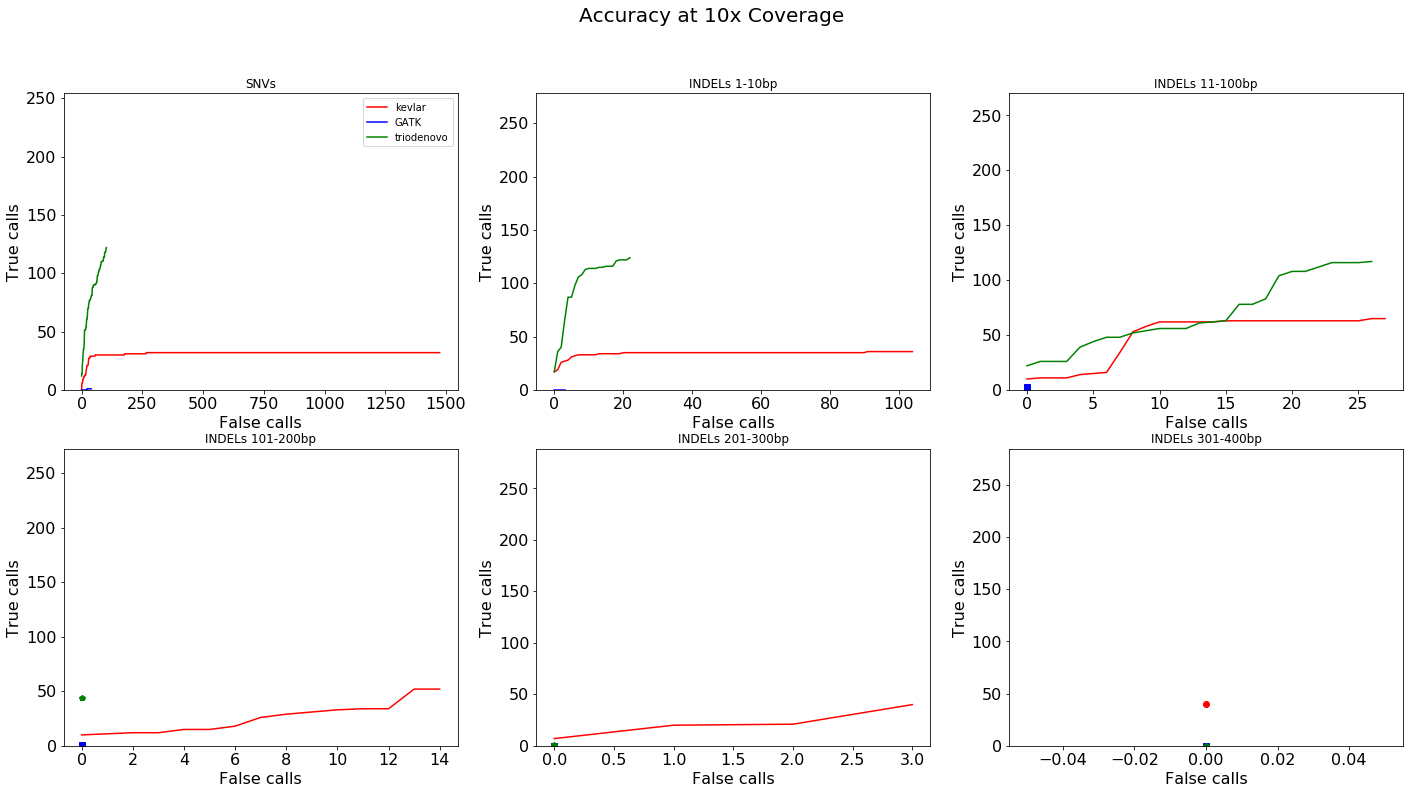

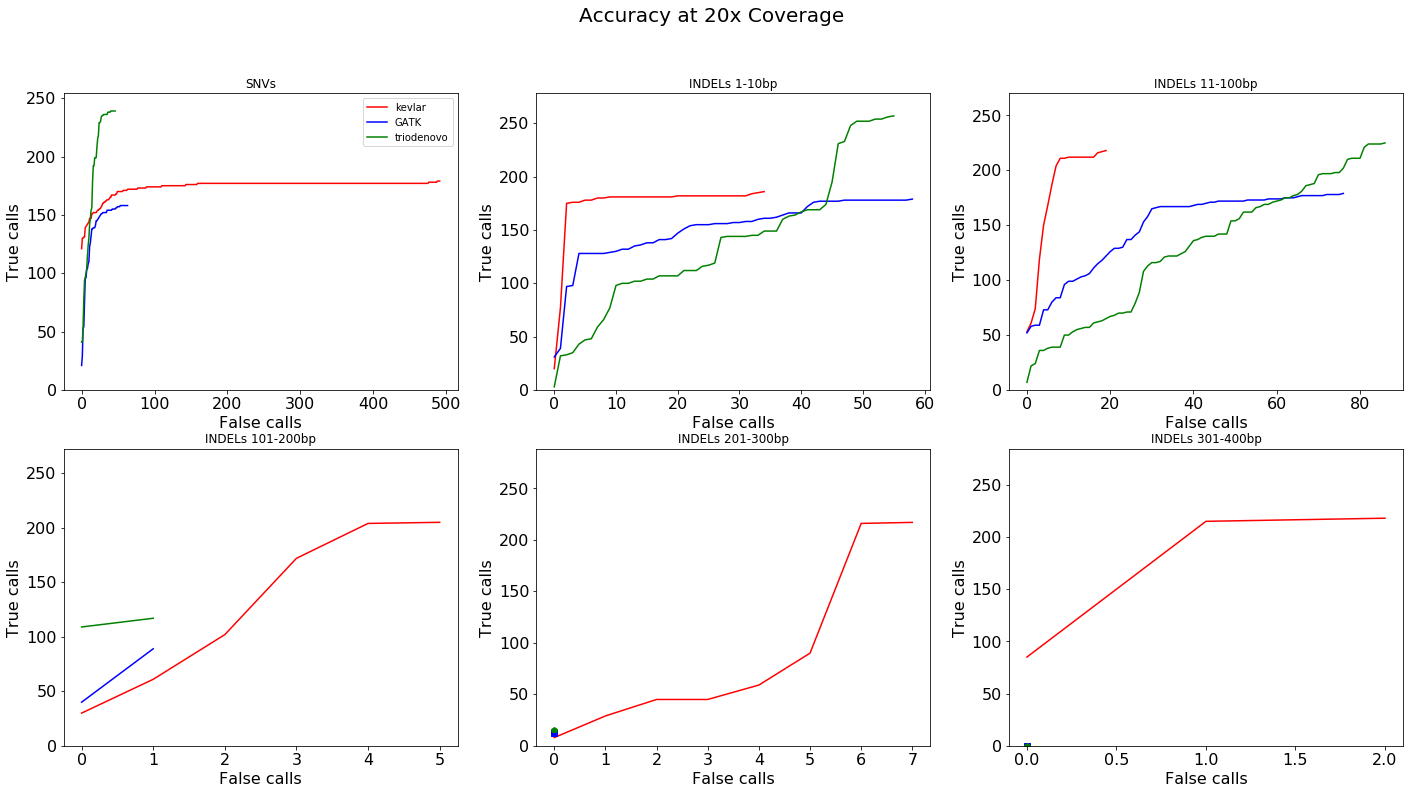

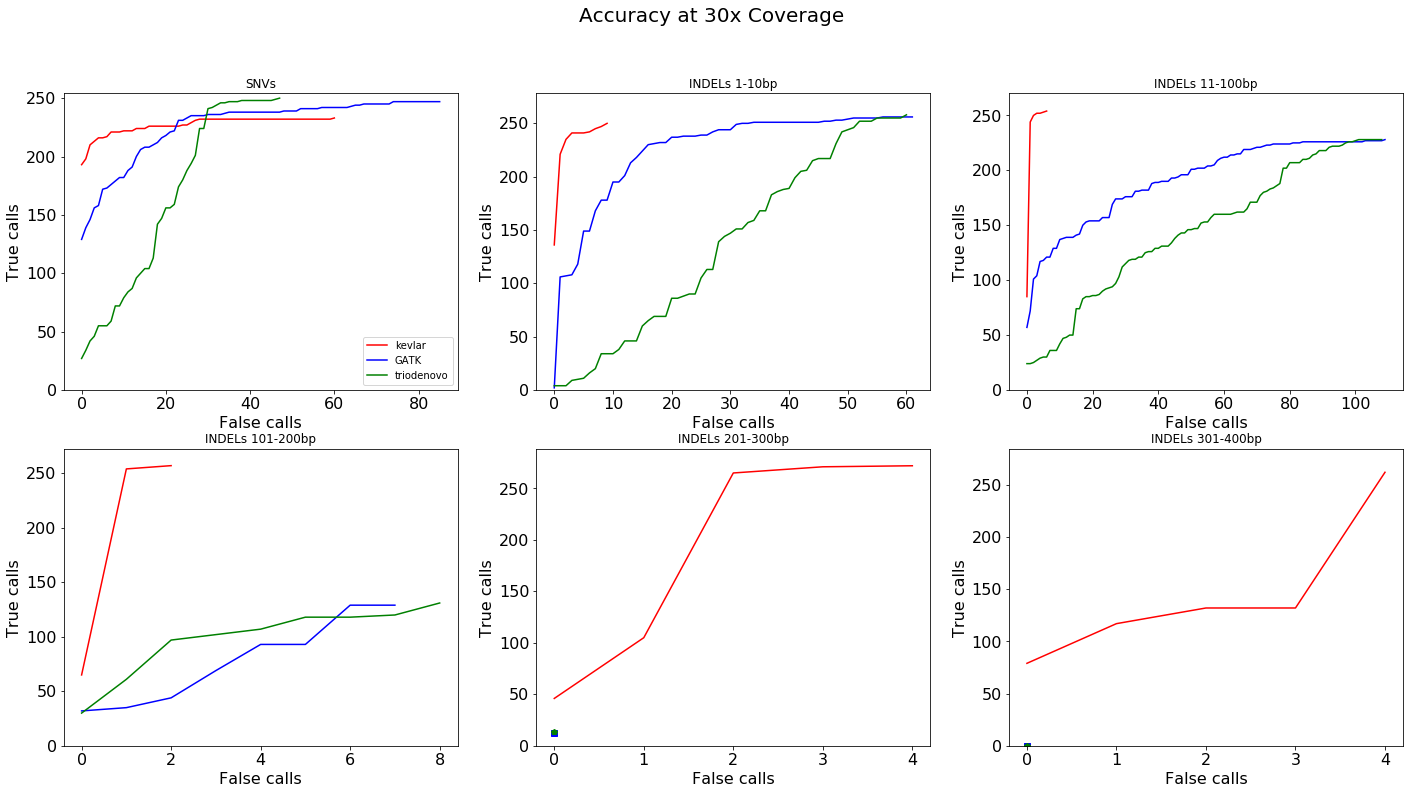

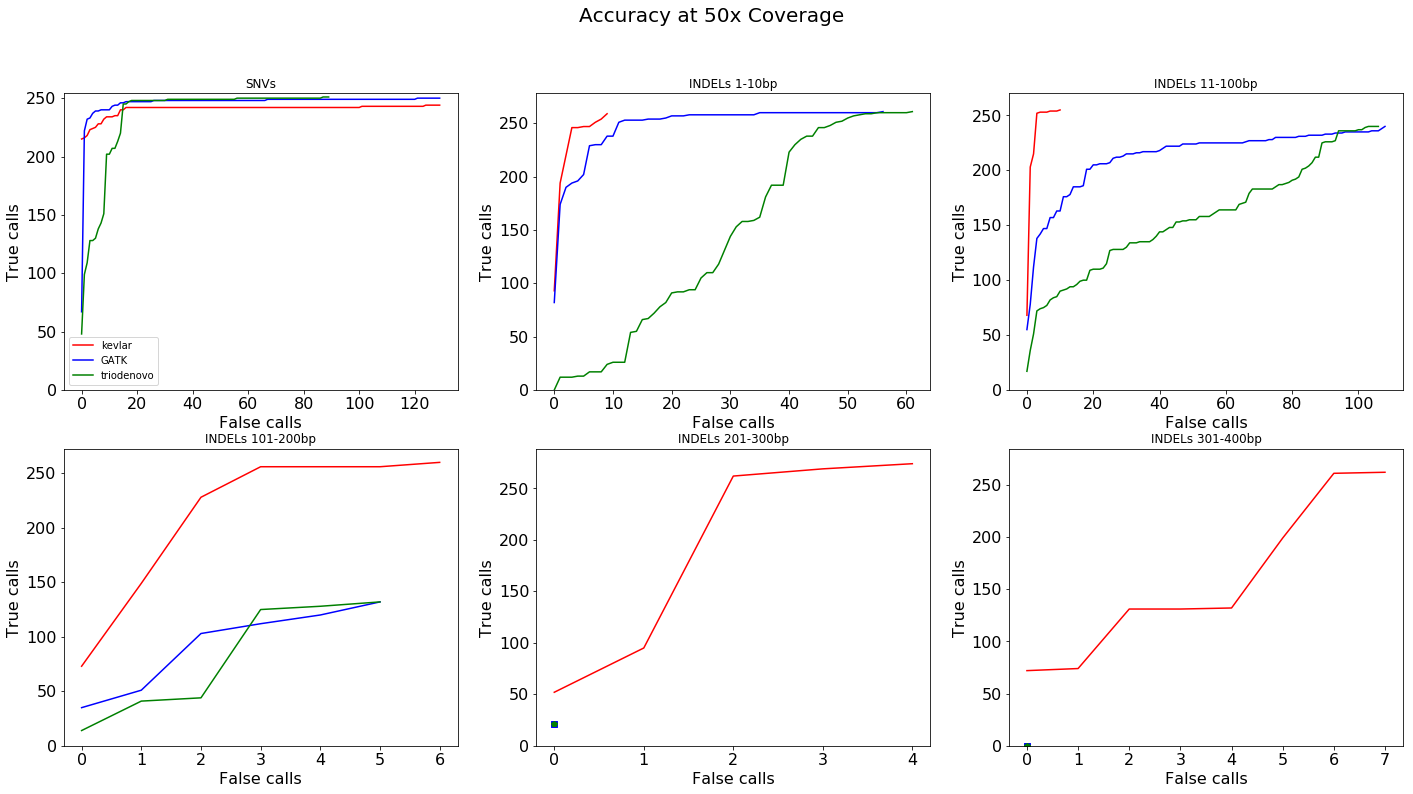

In [29]:
for cov in ('10', '20', '30', '50'):
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38.tsv.gz', 'r') as instream:
            indels = subset_variants(instream, vartype, minlength, maxlength)
            newindex = populate_index_from_simulation(indels, 'chr17')
        
        kevlar_tprs = roc_kevlar('kevlar_calls_'+ cov +'x.vcf.gz', newindex, delta=10, vartype=vartype, minlength=minlength, maxlength=maxlength)
        gatk_tprs = roc_gatk('GATK_calls_'+ cov +'x.mvf.gz', newindex, delta=10, vartype=vartype, minlength=minlength, maxlength=maxlength)
        triodenovo_tprs = roc_kevlar('triodenovo_calls_'+ cov +'x.vcf.gz', newindex, delta=10, vartype=vartype, minlength=minlength, maxlength=maxlength, triodenovocov=cov)
        
        nvariants = len(newindex.trees['chr17'])
        
        #print(dir(axis))
        doplot(axis, kevlar_tprs, 'red', 'kevlar', 'o')
        doplot(axis, gatk_tprs, 'blue', 'GATK', 's')
        doplot(axis, triodenovo_tprs, 'green', 'triodenovo', 'p')
        _ = axis.set_xlabel('False calls')
        _ = axis.set_ylabel('True calls')
        _ = axis.set_ylim((0, nvariants))
        _ = axis.set_title(label)
        if i == 0:
            _ = axis.legend()
    
    _ = plt.suptitle('Accuracy at '+ cov +'x Coverage', fontsize=20)
    _ = plt.savefig('three-callers-'+ cov +'x.png', dpi=300)
    _ = plt.show()

In [15]:
help(axis.plot)

Help on method plot in module matplotlib.axes._axes:

plot(*args, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)